In [3]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar  8 15:08:44 2022

@author: Wenhao Hsu
"""
from rdkit.Chem import AllChem
from rdkit import Chem
from sklearn import svm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from rdkit import DataStructs

In [4]:
def get_bits(fps):
    bits = []
    for fp in fps:
        bit_list = []
        for bit in fp:
            bit_list.append( int(bit) )
        bits.append(bit_list)
    return bits

def get_fp_mat( SMILES_list ):
    """
    do: generate the morgan-fingerprints and save it as matrix
    SMILES_list: The list of SMILES string
    OUTPUT: morgan-fingerprints matrix
    """
    fps = []
    for SMILES_string in SMILES_list:
        mol = Chem.MolFromSmiles(SMILES_string)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=2048).ToBitString()
        fps.append(fp)
    return get_bits(fps)


In [5]:
# get data set from filepath and do the data cleaning
dataset_path = './data/csv/washed_data_train.csv'
df = pd.read_csv(dataset_path)
df = df.dropna(subset=['Non_fixed?'])
df = df.reset_index(drop=True)
print('\nImported data from '+ dataset_path+', shape: '+str(np.shape(df)))
# df


Imported data from ./data/csv/washed_data_train.csv, shape: (246, 46)


In [6]:
# generate the morgan fingerprints and append it to dataframe
x = df['SMILES']
y = pd.DataFrame(df['lambda_onset']) 
y = np.ravel(y)
print('The shape of morgan-finger print as array x          : '+str(np.shape(x)))
print('The shape of feature as array y                      : '+str(np.shape(y)))

The shape of morgan-finger print as array x          : (246,)
The shape of feature as array y                      : (246,)


In [7]:
from FingerprintGenerator import *
import numpy as np
def get_MFF_df( MFF_dist ):
    """
    do: generate the MFF bitvectors and save it as matrix
    MFF_dist: The list of MFF string
    OUTPUT: morgan-fingerprints matrix
    """
    for i in MFF_dist:
        bit_string = MFF_dist[i].ToBitString()
        bit_list = []
        for bit in bit_string:
            bit_list.append( int(bit) )
        MFF_dist[i] = bit_list
    MFF_dist = [MFF_dist]
    MFF_df = pd.DataFrame(MFF_dist)
    return MFF_df

FG = FingerprintGenerator()
MFF_dfs = []
for index,row in df.iterrows():
    smile_string = row['SMILES']
    mol = Chem.MolFromSmiles(smile_string)
    MFF_dist = FG.generateArrofFingerprints(mol)
    MFF_df = get_MFF_df(MFF_dist)
    try:
        MFF_dfs = pd.concat([MFF_dfs,MFF_df],ignore_index=True)
        # print(np.shape(MFF_dfs))
    except Exception as e:
        MFF_dfs = MFF_df
        # print(np.shape(MFF_dfs))

In [9]:
MFF_dfs.to_csv('./data/csv/washed_data_MFF.csv')
# MFF_new = pd.read_csv('./data/csv/washed_data_MFF.csv')


In [1]:
import warnings
warnings.simplefilter("ignore")

from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import pearsonr

import csv

models=[LinearRegression(),KNeighborsRegressor(),Ridge(),LassoCV()]
models_str=['Linear Regression','KNNRegressor','Ridge','Lasso']

for model,model_name in zip(models,models_str):
    predictors = MFF_dfs.columns.values.tolist()
    MAPE_dict   = {}
    score_dict = {}
    for parameter in predictors:
        para_df = pd.DataFrame(MFF_dfs[parameter])
        new_df= []
        for index,row in para_df.iterrows():
            new_row = pd.DataFrame(row[parameter])
            new_row = pd.DataFrame(new_row.values.T,index=new_row.columns,columns=new_row.index)
            new_df.append(new_row)
            try:
                new_df = pd.concat([new_df,new_row])
            except Exception as e:
                new_df = new_row
        new_df = pd.DataFrame(new_df)
        para_df = pd.concat([para_df.reset_index(), new_df.reset_index()], axis=1).drop([parameter,'index'], axis=1).reset_index()
        x = para_df
        x['Mol.wt'] = df['Mol.wt']
        x['Non_fixed?'] = df['Non_fixed?']
        y = pd.DataFrame(df['lambda_onset']) 

        # do a random split
        x_train, x_test, y_train, y_test = train_test_split( x, y,test_size=0.2,random_state=2022)
        # from sklearn.preprocessing import StandardScaler
        # ss=StandardScaler()
        # x_train_ss=ss.fit_transform(x_train)
        # x_test_ss=ss.transform(x_test)
        # y_train = np.ravel(y_train)
        # y_test = np.ravel(y_train)

        #拟合
        model.fit(x_train,y_train)
        y_pred = model.predict(x_test)

        # 评估
        score=model.score(x_test, y_test)
        score_dict[parameter] = score
        CCs = pearsonr(np.ravel(y_test),np.ravel(y_pred))
        MAE = mean_absolute_error(y_test,y_pred)
        MSE = mean_squared_error(y_test,y_pred)
        MAPE = mean_absolute_percentage_error(y_test,y_pred)
        MAPE_dict[parameter] = MAPE

        # 保存数据
        np.save('./data/npy/MFF_score_'+model_name+'.npy', score_dict)
        np.save('./data/npy/MFF_mape_'+model_name+'.npy', MAPE_dict)


        # 可视化
        # print('\nLasso + '+ parameter)
        # print('Scikit score                          : '        + str(score)
        #     + '\npearsonr                              : '        + str(CCs)
        #     + '\nmean_absolute_error                   : '        + str(MAE)
        #     + '\nmean_squared_error                    : '        + str(MSE)
        #     + '\nmean_absolute_percentage_error        : '        + str(MAPE)
        # )


NameError: name 'MFF_dfs' is not defined

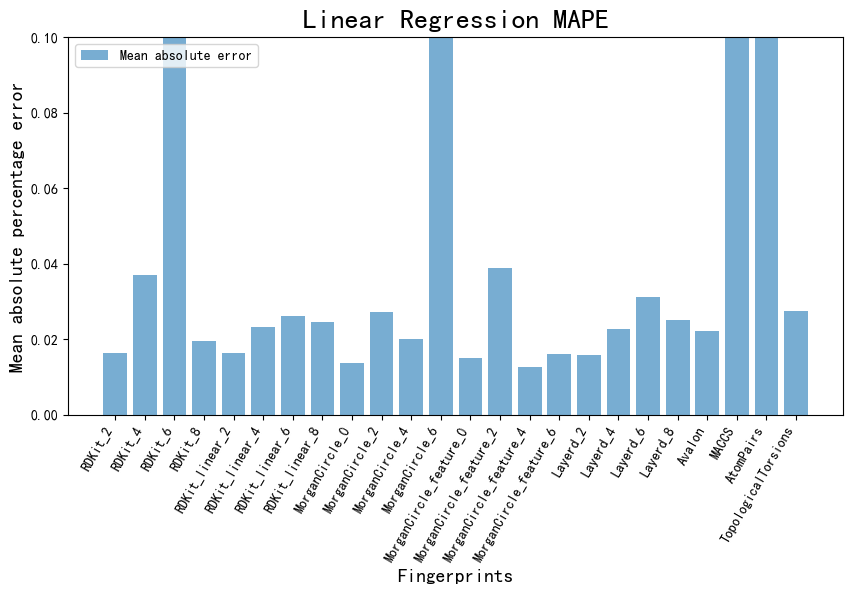

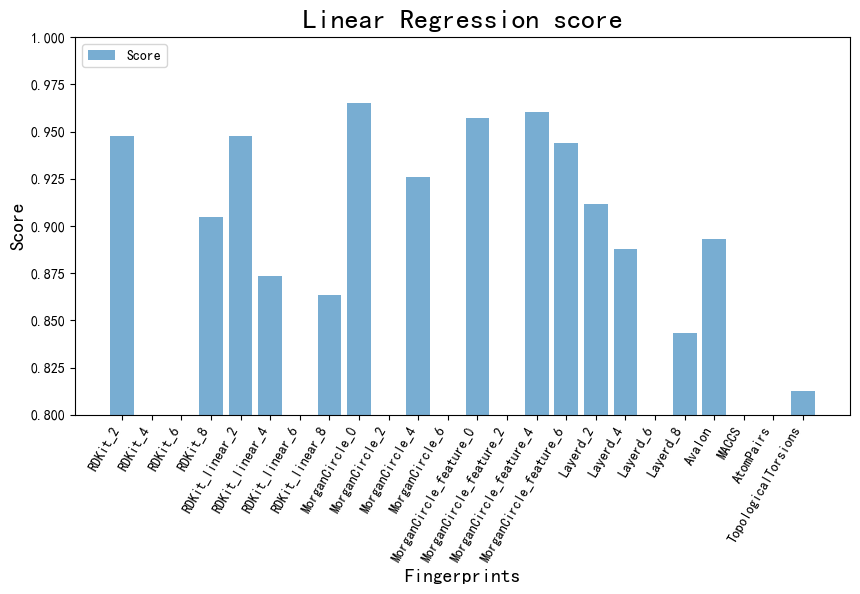

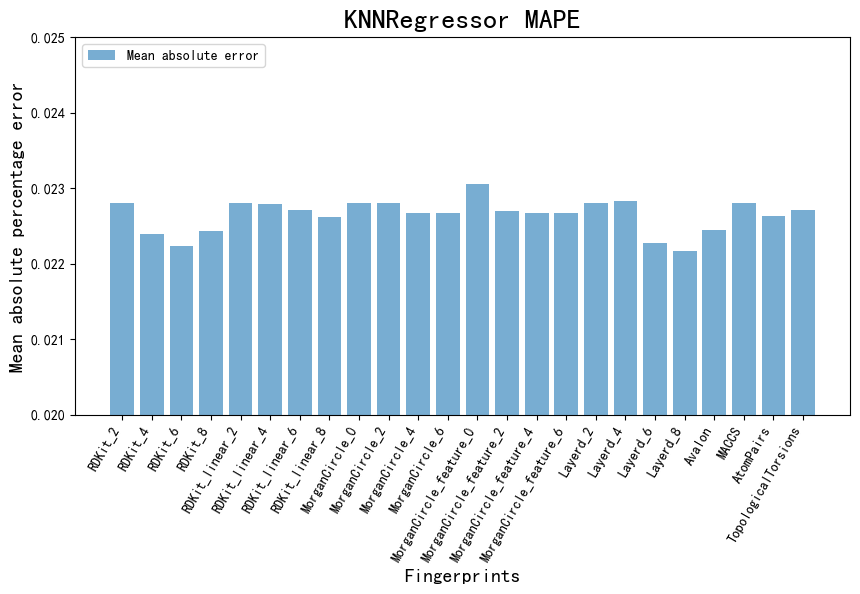

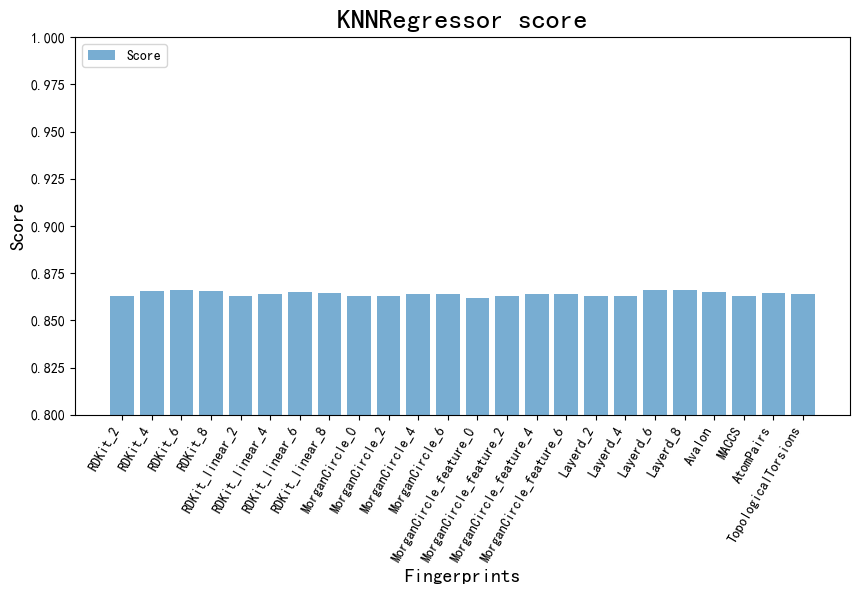

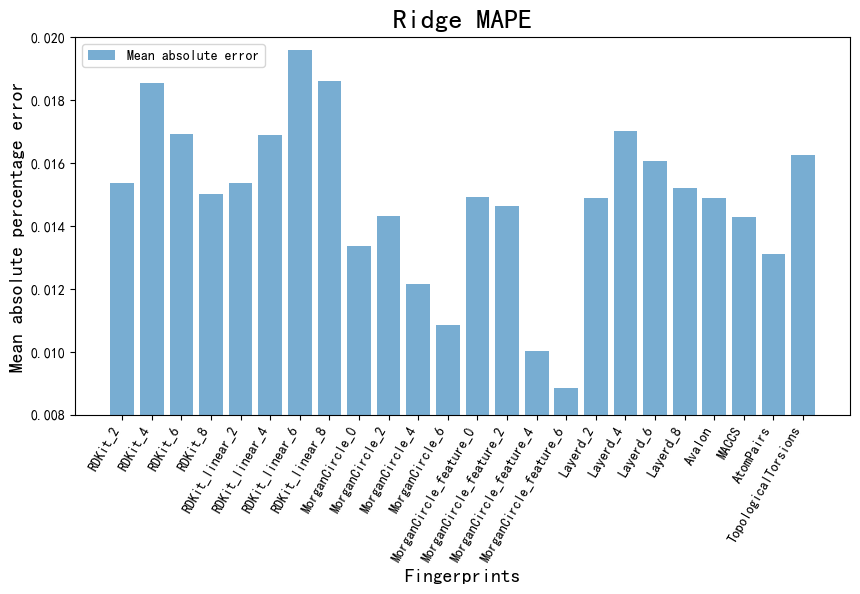

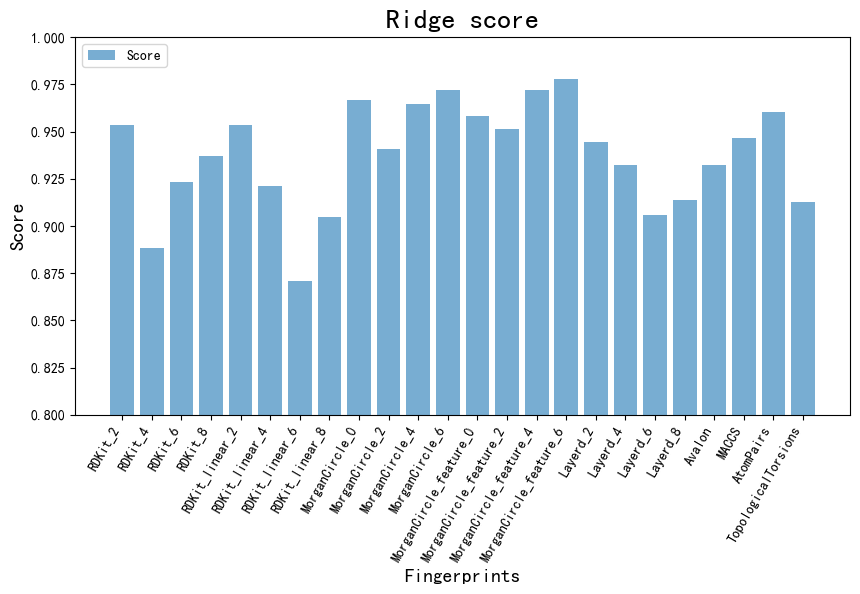

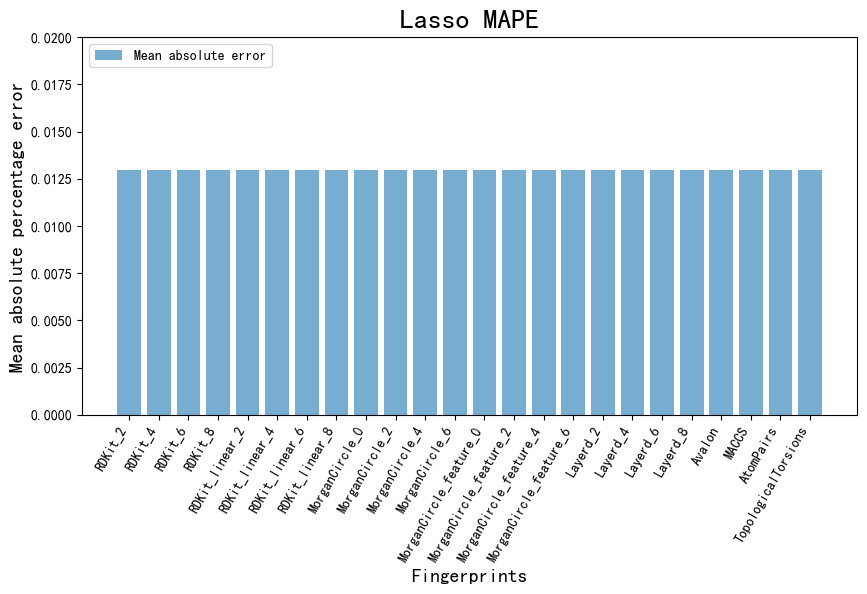

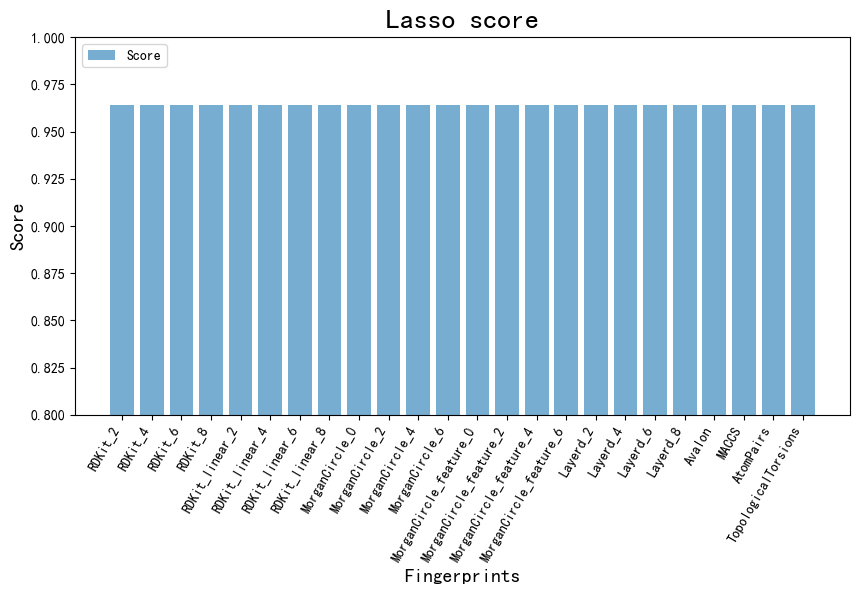

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

MAPE_plot_config_ylim={'Linear Regression':(0,.1),'KNNRegressor':(.02,.025),'Ridge':(.008,.02),'Lasso':(0,.02)}
for model_name in models_str:
    MAPE_dict   = np.load('./data/npy/MFF_mape_'+model_name+'.npy', allow_pickle='TRUE').item()
    score_dict = np.load('./data/npy/MFF_score_'+model_name+'.npy', allow_pickle='TRUE').item()
    plt.rcParams['image.interpolation'] = 'nearest' # 设置 interpolation style
    plt.rcParams['savefig.dpi'] = 200 #图片像素
    plt.rcParams['figure.dpi'] = 100 #分辨率
    matplotlib.rcParams['font.sans-serif']=['SimHei']   #用黑体显示中文
    matplotlib.rcParams['axes.unicode_minus']=False     #正常显示负号


    data_key = [ key for key,value in MAPE_dict.items() ]
    data_vale = [ value for key,value in MAPE_dict.items() ]
    plt.figure(figsize=(10,5)) #设置画布的尺寸
    plt.title(model_name+' MAPE',fontsize=20) #标题，并设定字号大小
    plt.xlabel(u'Fingerprints',fontsize=14) #设置x轴，并设定字号大小
    plt.ylabel(u'Mean absolute percentage error',fontsize=14) #设置y轴，并设定字号大小
    plt.xticks(rotation=60,ha = 'right')
    plt.bar(data_key,data_vale, alpha=0.6,width = 0.8, lw=1,label= 'Mean absolute error') #alpha：透明度；width：柱子的宽度；facecolor：柱子填充色；edgecolor：柱子轮廓色；lw：柱子轮廓的宽度；label：图例；
    plt.ylim(MAPE_plot_config_ylim[model_name]) #y轴区间
    plt.legend(loc=2) #图例展示位置，数字代表第几象限
    plt.show() #显示图像

    data_vale = [ value for key,value in score_dict.items() ]
    data_key = [ key for key,value in score_dict.items() ]
    plt.figure(figsize=(10,5))#设置画布的尺寸
    plt.title(model_name+' score',fontsize=20)#标题，并设定字号大小
    plt.xlabel(u'Fingerprints',fontsize=14)#设置x轴，并设定字号大小
    plt.ylabel(u'Score',fontsize=14)#设置y轴，并设定字号大小
    plt.xticks(rotation=60,ha = 'right')
    plt.bar(data_key,data_vale, alpha=0.6,width = 0.8, lw=1,label= 'Score') #alpha：透明度；width：柱子的宽度；facecolor：柱子填充色；edgecolor：柱子轮廓色；lw：柱子轮廓的宽度；label：图例；
    plt.ylim((.8, 1))
    plt.legend(loc=2)#图例展示位置，数字代表第几象限
    plt.show()#显示图像